<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Marvin Reuter
* Matriculation number: 11139466
* Date:   20.11.2024

---------------------------------

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the abalone data set (downloaded from UCI) and uses its outputs for explanation of feature importance using the SHAP explainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated. 

For a description of the features please refer to <a href="https://archive.ics.uci.edu/dataset/1/abalone">UCI abalone data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  

## Imports
Import all necessary utilities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shap import initjs
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

c:\Users\marvi\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [5]:
data = pd.read_csv("./data/abalone/abalone.data", names=["sex","length","diameter","height", 
                                                         "whole weight","shucked weight", "viscera weight","shell weight","rings"])
                         
#Get features
y = data['rings']
X = data[["sex","length","height","shucked weight","viscera weight","shell weight"]]

In [6]:
# do some necessary preprocessing
X.loc[X['sex'] == 'M', 'sex.M'] = 1
X.loc[X['sex'] == 'F', 'sex.F'] = 1
X.loc[X['sex'] == 'I', 'sex.I'] = 1

X = X.drop('sex', axis=1)

C:\Users\marvi\AppData\Local\Temp\ipykernel_57908\2405591408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['sex'] == 'M', 'sex.M'] = 1
C:\Users\marvi\AppData\Local\Temp\ipykernel_57908\2405591408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['sex'] == 'F', 'sex.F'] = 1


### Build a simple ML model and fit it.

In [7]:
model = xgb.XGBRegressor() 
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

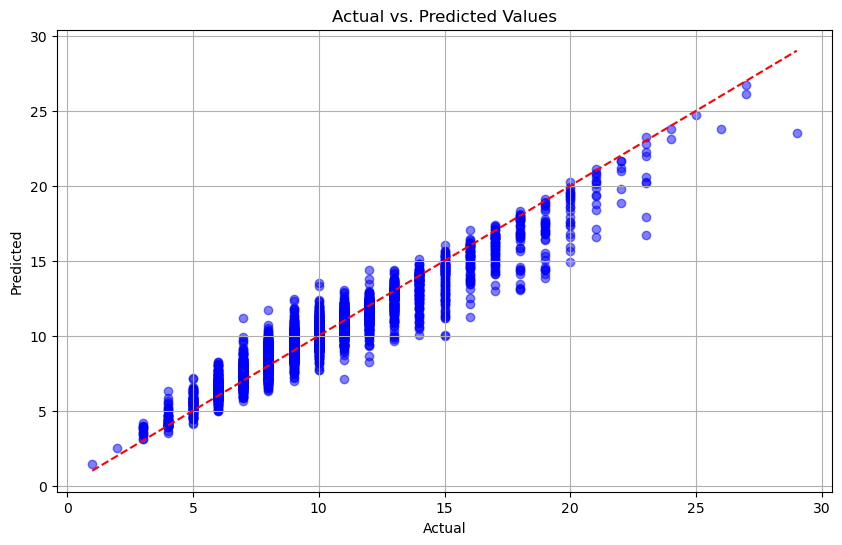

In [8]:
# Make predictions on the test set
y_pred = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, color='b')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Values")

# Plot the diagonal line for reference
max_val = max(np.max(y), np.max(y_pred))
min_val = min(np.min(y), np.min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed')

plt.grid(True)
plt.show()

### <font color=red>NOTE:</font>

Even though we did not put much love into our model, the results are quite ok. However, please keep in mind, that you should start computing Shapley value if and only if you have optimized your model. You do not have to be a genius to understand that the better the model, the better the Shapley values. 

### Now, compute the Shaley values

These are the two essential lines of code. Pass your model into the SHAP Explainer function. 
This creates an explainer object. The, use this to calculate SHAP values for every observation in the feature matrix.

In [9]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

----------------------------------------------
### Visualization section
----------------------------------------------

#### Waterfall plot for first observation

There are 8 Shapley values for each of the 4177 observations in the feature matrix. 
That is one Shapley value for each feature in your model. You can use the waterfall function to visualise the Shapley values of the first observation.

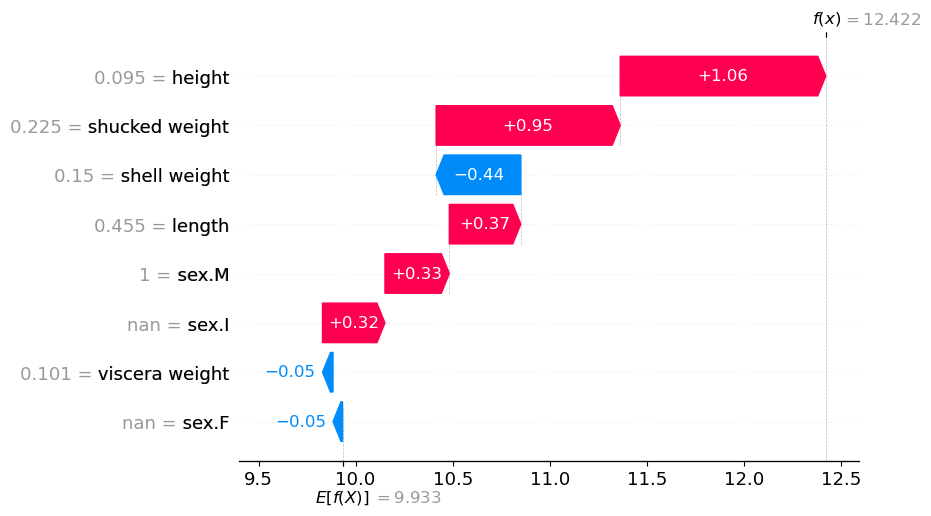

In [10]:
shap.plots.waterfall(shap_values[0])

##### <font color="ce33ff">Interpretation:</font>

**E[f(x)] = 9.933** gives the average predicted number of rings across all 4177 abalones. 
**f(x) = 13.043** is the predicted number of rings for this particular abalone. 
The Shapley values are all the values in between. 
For example, the shucked weight contributes to the total predicted number by an increase of **1.68**.

There is a unique waterfall plot for every observation of an abalone in your dataset. They can all be interpreted in the same way as above. In each case, the Shapley values tell us how the features have contributed to the prediction when compared to the average prediction. Large positive/negative values indicate that the feature had a significant impact on the model’s prediction.

#### Forceplot for first observation

In [11]:
shap.plots.force(shap_values[0])

##### <font color="ce33ff">Interpretation:</font>

Another way to visualise these individual feature contributions is using a so-called force plot. 
Think of it as a condensed waterfall plot. It starts at the same base value of **9.933** and you can see how each feature has contributed to the final prediction of **13.04**.

#### Entire/Stacked force plot

Waterfall and force plots are great for interpreting individual predictions (see above). To understand how your model makes predictions in general you need to aggregate the Shapley values. One way to do this is by using the so-called stacked-force plot.

You can combine multiple force plots together to create a stacked force plot. In this example pass the Shapley values for the first 100 observations in the force plot function. Each individual force plot is now vertical and stacked side by side.

Since this plot is interactive, you can change the ordering of the plots and choose which feature contributions to display.

In [12]:
shap.plots.force(shap_values[0:100])

##### <font color="ce33ff">Interpretation:</font>

For example, select "shell weight" on x-axis and "shell weight effects" on the y-axis.
Now, from the appearing plot you can see that as shell weight increases the Shapley values also increase. 
Since this is a function of age, older abalones tend to have heavier shells.

This is one way to understand the nature of the relationships captured by the model. 
Now, you will learn that the so-called beeswarm plot and dependence plots can also be used this way.

#### Mean SHAPLEY values

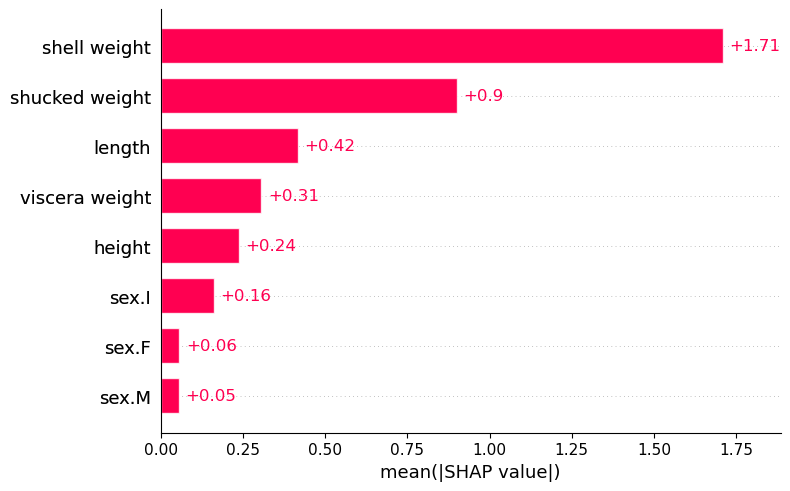

In [13]:
shap.plots.bar(shap_values)

##### <font color="ce33ff">Interpretation:</font>
This bar plot tells you which features are most important. 
For each and every feature, it calculates the mean Shapley value across all observations. 

Specifically, it takes the mean of the absolute values as it does not want positive and negative values to offset each other. 
There is one bar for each feature in the data set. You can easils see, that "shell weight" has the largest mean Shapley value.

Features that have made large positive/negative contributions will show a large mean Shapley value. In other words, these are the features that have had a significant impact on the model’s predictions. Hence, this bar plot can be used in the same manner as a feature importance plot.

#### Beeswarm plot

The so-called beeswarm plot is one of the most useful plots. The beeswarm visualises all of the SHAP values. 
On the y-axis, the values are grouped by feature. For each group, the colour of the points is determined by the feature value (i.e. higher feature values are more red - see legend ).

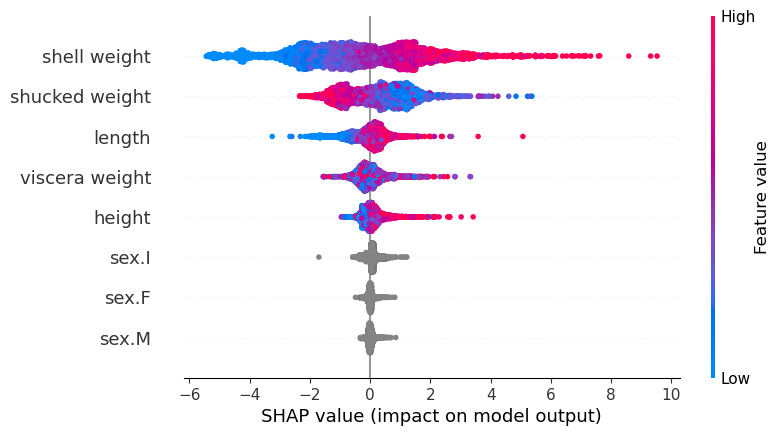

In [14]:
shap.plots.beeswarm(shap_values)

##### <font color="ce33ff">Interpretation:</font>

The features in the above plot are ordered by mean SHAP value.

E.g., for "shell weight", you will notice, that SHAP values increase when the feature value increases. 
Remember, you saw a similar relationship in the stacked force plot. It tells you that larger values for "shell weight" will lead to a higher predicted number of label value "rings".

You may also notice, that the feature "shucked weight" shows the opposite relationship. 
Looking at the beeswarm plot, we can see that larger values for this feature are associated with smaller SHAP values. 

##### Heatmap

Passing the matrix of 200 Shapley values to the heatmap plot function creates a plot with the instances on the x-axis, the model features on the y-axis, and the Shapley values encoded on a color scale. By default, the samples are ordered based on a hierarchical clustering by their explanation similarity. 
This results in samples that have the same model output for the same reason getting grouped together.

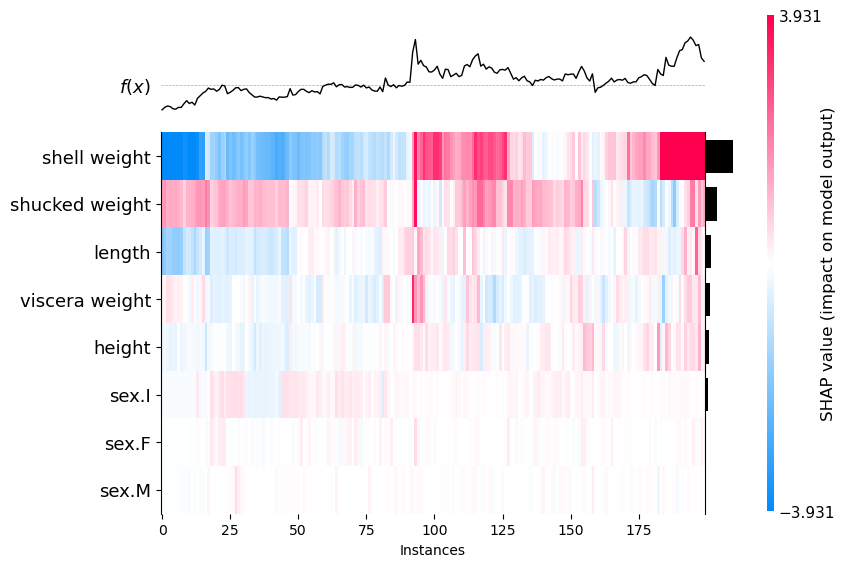

<Axes: xlabel='Instances'>

In [15]:
shap.plots.heatmap(shap_values[:200])

##### <font color="ce33ff">Interpretation:</font>

The output of the model is shown above the heatmap matrix (centered around the explaination’s average value), and the global importance of each feature shown as a bar plot on the right hand side of the plot (by default this is the average measure of overall importance).

#### Dependence plots of the Shapley values 

A dependence plot is a scatter plot of the Shapley value vs. the feature value for one single feature. 
They are particularly useful if the feature has got a non-linear relationship with the label.

##### Plot 1: shell weight

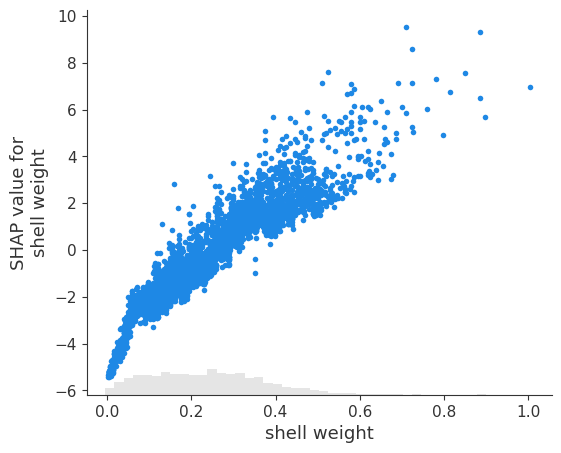

In [16]:
shap.plots.scatter(shap_values[:,"shell weight"])

##### <font color="ce33ff">Interpretation:</font>

For example, take the dependence plot for "shell weight" feature. 
Looking at the beeswarm plot we may have assumed that the Shapley values increase linearly with the feature value. 
However, this dependency plot shows you that the relationship is not perfectly linear. That is very useful.

##### Plot 2: shucked weight

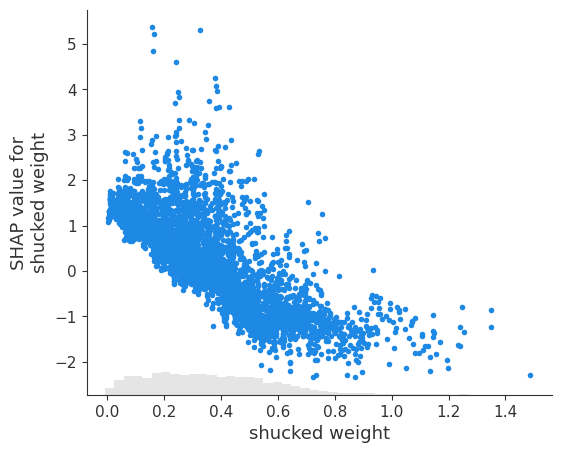

In [17]:
shap.plots.scatter(shap_values[:,"shucked weight"])

##### <font color="ce33ff">Interpretation:</font>
The dependency plot for "shucked weight" (i.e the weight of the abalone meat). 
Using this plot you can see and confirm the relationship you saw in the beeswarm plot already. 
The SHAP values do decrease as shucked weight increases.

##### Plot 3: shell weight & shucked weight

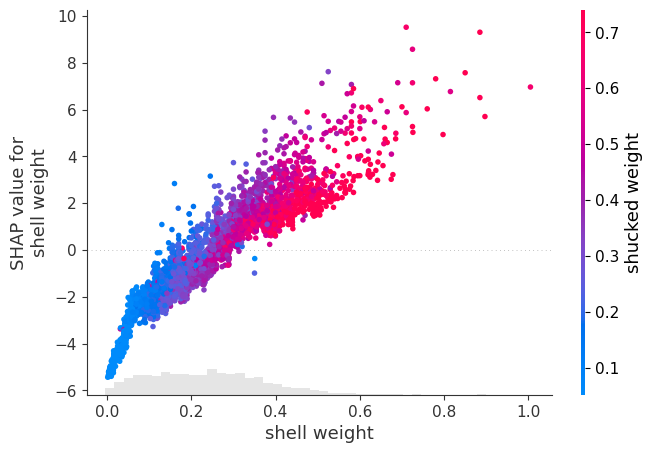

In [18]:
shap.plots.scatter(shap_values[:,"shell weight"],
                   color=shap_values[:,"shucked weight"])

##### <font color="ce33ff">Interpretation:</font>
This plot can be used to visualise interactions between features. BUT be cautious! 
In your case, the plot is a result of the correlation between the two features.

Intuitively, this relationship seems strange. 

Wouldn’t you expect an older abalone to be larger and having more meat? 

This is, in fact, a result of an interaction between "shell weight" and "shucked weight". 
You could not see it in the dependence plot due to the correlation. 

 # TASK: 
 #### Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  

In [27]:
import shap # v0.44.0
import numpy as np # v1.26.4

import tensorflow as tf # v2.15.0
from   tensorflow import keras
import matplotlib.pyplot as plt
from   tensorflow.keras.models import Sequential
import ssl

In [2]:
print(shap.__version__)
print(np.__version__)
print(tf.__version__)

0.44.0
1.26.4
2.15.0


## load build-in dataset
take the cifar-10 data set from exercise 8

In [45]:
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# reshape and normalize data
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

In [46]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="test_for_shap")
# compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 200)

Epoch 1/200
1563/1563 [==============================] - 38s 23ms/step - loss: 1.3894 - sparse_categorical_accuracy: 0.5006 - val_loss: 1.2017 - val_sparse_categorical_accuracy: 0.5677
Epoch 2/200
1563/1563 [==============================] - 35s 22ms/step - loss: 1.0549 - sparse_categorical_accuracy: 0.6266 - val_loss: 1.0917 - val_sparse_categorical_accuracy: 0.6125
Epoch 3/200
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8944 - sparse_categorical_accuracy: 0.6872 - val_loss: 1.0057 - val_sparse_categorical_accuracy: 0.6528
Epoch 4/200
1563/1563 [==============================] - 31s 20ms/step - loss: 0.7468 - sparse_categorical_accuracy: 0.7365 - val_loss: 1.0142 - val_sparse_categorical_accuracy: 0.6603
Epoch 5/200
1563/1563 [==============================] - 31s 20ms/step - loss: 0.6189 - sparse_categorical_accuracy: 0.7841 - val_loss: 1.1025 - val_sparse_categorical_accuracy: 0.6407
Epoch 6/200
1563/1563 [==============================] - 31s 20ms/step - lo

In [47]:
# class label list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# example image for each class
images_dict = dict()

for i, l in enumerate(y_train):
    if len(images_dict)==10:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict)==10:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]
        
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 145ms/step


In [48]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()
  
    # plot
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')
    
    # plot image
    for k,v in images.items():
        ax = axes[k+1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

#### XAI using SHAP
Now use the SHAP library to generate the Shapley values

In [49]:
# select background for shap to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

# use the Explainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(x_test_each_class[:10])

# compute the shapley values
#shap_values = explainer.shap_values(x_test_each_class)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


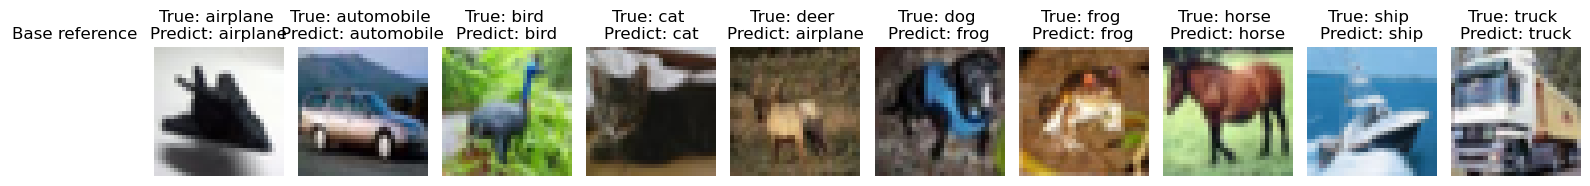

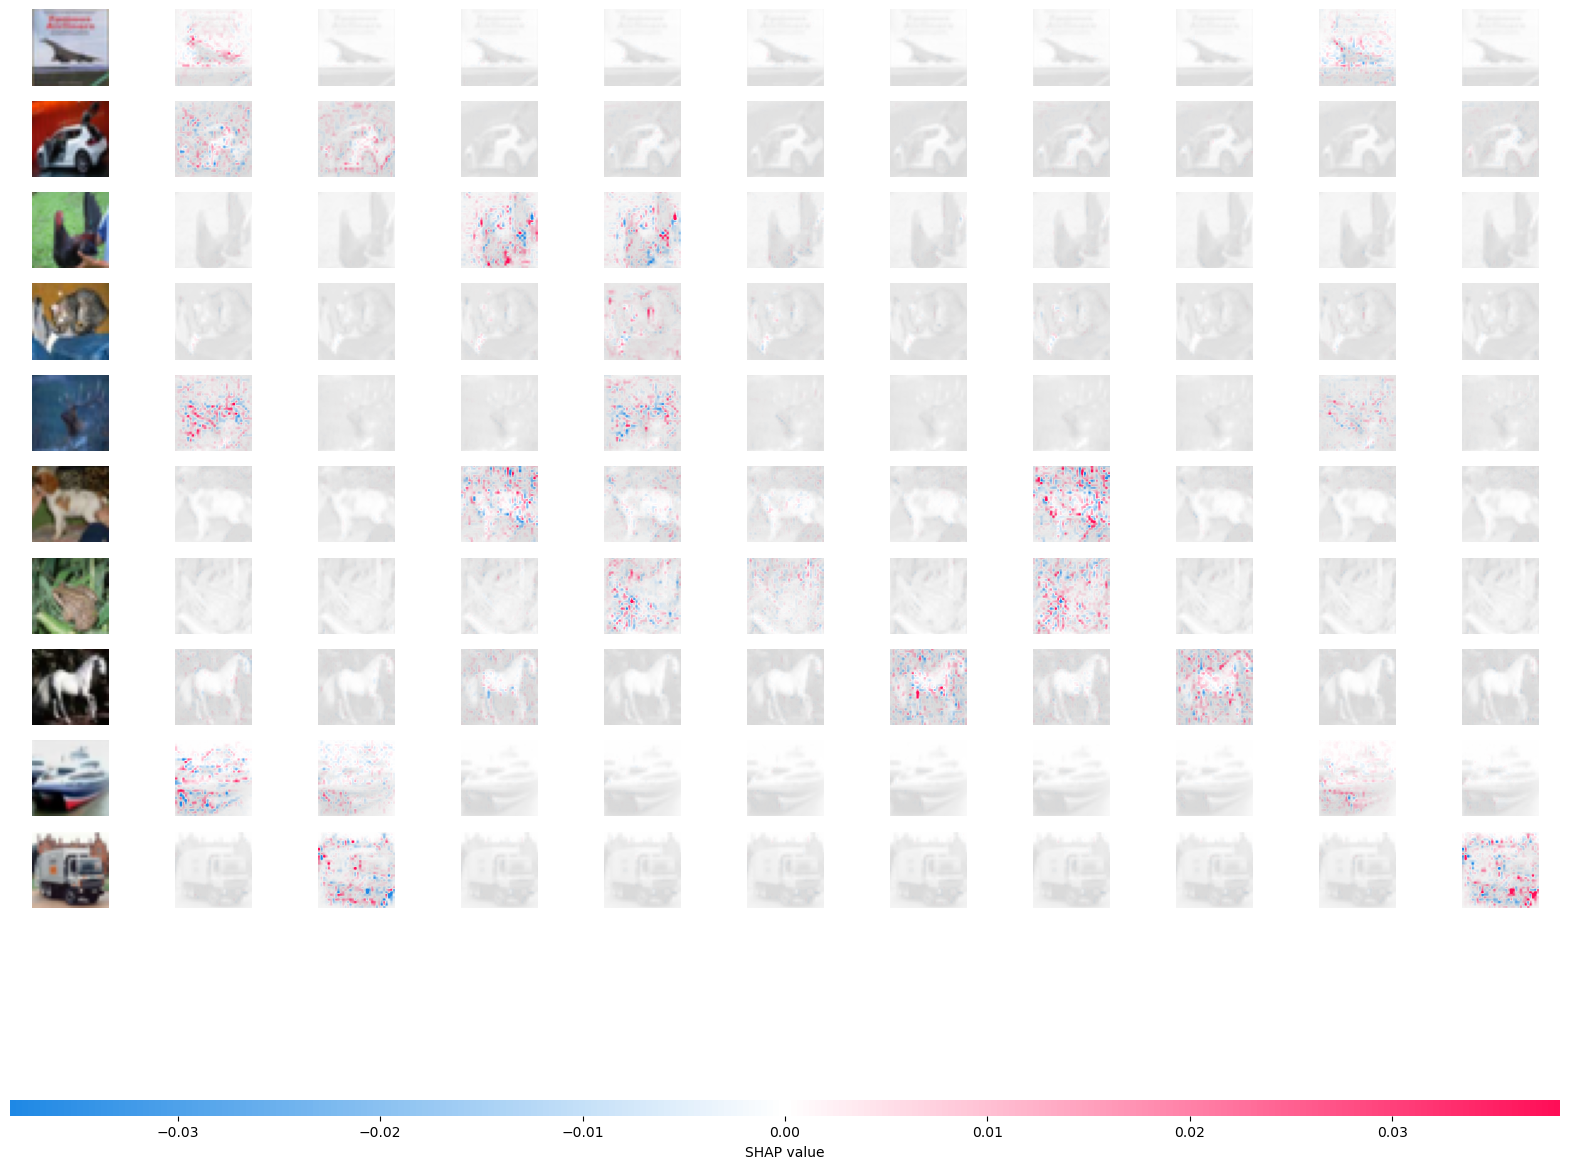

In [50]:
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class[:10])